# TITANIC DATASET
Link: https://www.kaggle.com/c/titanic/data

##   Read   datasets  Train and test

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

train = pd.read_csv('train.csv')
train= train.set_index('PassengerId')
test = pd.read_csv('test.csv')
test= test.set_index('PassengerId')

In [3]:
train.head(n=10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [4]:
train.shape

(891, 11)

## Cleaning Data

In [5]:
train.isnull().sum(axis = 0)

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

##### Cabin has too many missing values:   687 out of 891

In [6]:
test.isnull().sum(axis = 0)

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

#### On test set, cabin has too many missing values

In [7]:
pd.crosstab(train['Embarked'], columns='count')

col_0,count
Embarked,
C,168
Q,77
S,644


In [8]:
train['Embarked'].fillna(value='S',inplace=True)

#####  Filling 'Fare' missing values by grouping classes

In [9]:
test['Fare'] = test.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median())) 

#### Creating new variable 'Title' before filling missing values in 'Age'

In [10]:
#2
Title_Dictionary = { "Capt": "Officer",    "Col": "Officer",  "Major": "Officer",
                     "Jonkheer": "Royalty","Don": "Royalty",  "Sir" : "Royalty",
                     "Dr": "Officer",      "Rev": "Officer",  "the Countess":"Royalty",
                     "Mme": "Mrs",         "Mlle": "Miss",    "Ms": "Mrs",
                     "Mr" : "Mr",          "Mrs" : "Mrs",     "Miss" : "Miss",
                     "Master" : "Master",  "Lady" : "Royalty", "Dona": "Royalty"
}

def get_titles(combined):
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)
    #status('Title')
    return combined

In [11]:
train= get_titles(train)
test = get_titles(test)

In [12]:
pd.crosstab(test['Title'], columns='count')

col_0,count
Title,
Master,21
Miss,78
Mr,240
Mrs,73
Officer,5
Royalty,1


In [13]:
pd.crosstab(train['Title'], columns='count')

col_0,count
Title,
Master,40
Miss,184
Mr,517
Mrs,127
Officer,18
Royalty,5


It's important to verify that the new variable contains all values in test and train for modelization purposes

### Filling 'Age' missing values by grouping Sex and Title, using median of each group

In [14]:

train['Age'] = train.groupby(['Sex', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))

test['Age'] = test.groupby(['Sex', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))

# EDA and Data Visualization

In [15]:
train.groupby(['Pclass'])['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

It's seen in last table that 62% of passengers in First Class survived!!
However, only the 24% in Third class survived.

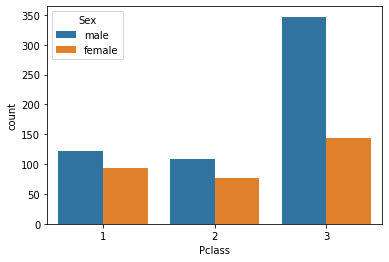

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.countplot(x="Pclass", hue="Sex", data=train);

In [17]:
train.groupby(['Pclass','Sex'])['Survived'].mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

This table provides even more interesting facts. 96% of women in First Class survived, meanwhile 50% of women survived in the Third Class. In the other hand, the percentage of surviving for men when from 36% in 1st class to 13% in 3rd class.

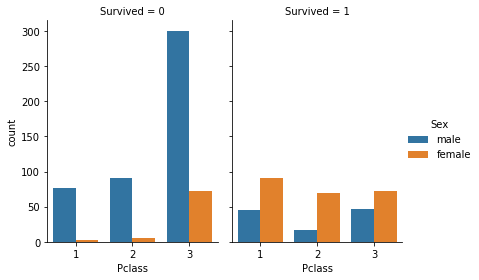

In [18]:
sns.catplot(x="Pclass", hue="Sex", col="Survived",
                data=train, kind="count",
                height=4, aspect=.7);

*  Men died in identical proportion in any Class, slightly less for Class 1
* Being a woman gave you more chances to survive, class 3 died in same proportion

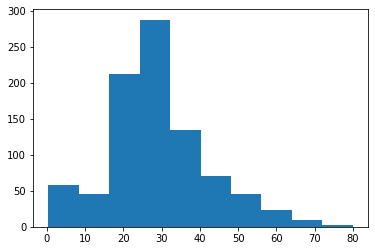

In [19]:
plt.hist(train.Age);

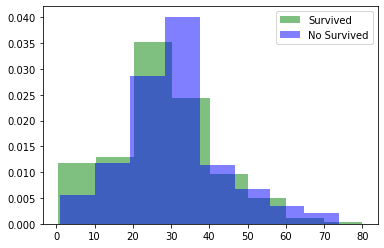

In [20]:
x1 = train.Age[train.Survived==1]
x2 = train[train.Survived==0]['Age']

# Normalize
kwargs = dict(alpha=0.5, bins=8, density=True, stacked=True)  # 8 bins for 8 groups of age, 0 -10 , 11 - 20, ...

plt.hist(x1, **kwargs, color='g', label='Survived');      # green
plt.hist(x2, **kwargs, color='b', label='No Survived');   # blue
plt.legend();

#### By the last graph, it's noticeable that the youngest were more able to survive.

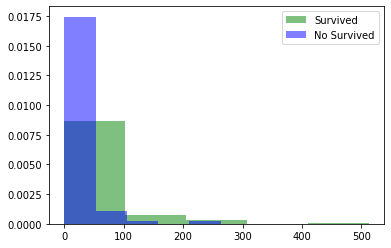

In [21]:
x1 = train.Fare[train.Survived==1]
x2 = train[train.Survived==0]['Fare']  # other way to rewrite

# Normalize
kwargs = dict(alpha=0.5, bins=5, density=True, stacked=True)  # 5 bins for 5 groups of Fare, 0 -50 , 51 - 100, ...

plt.hist(x1, **kwargs, color='g', label='Survived');      # green
plt.hist(x2, **kwargs, color='b', label='No Survived');   # blue
plt.legend();

#### The more you paid the more chances you had to survive

# Feature Engineering

##### * I already created one variable 'Title' for filling missing values

### New variable 'family':
it depends on  of siblings / spouses aboard the Titanic as well as # of parents / children on board the Titanic

In [22]:
train['family']=train['SibSp']+train['Parch']+1
test['family']=test['SibSp']+test['Parch']+1

In [23]:
train.groupby(['family'])['Survived'].mean()

family
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

In [24]:
train['Alone'] = train['family'].apply(lambda x: 1 if x == 1 else 0)
test['Alone'] = test['family'].apply(lambda x: 1 if x == 1 else 0)

In [25]:
train.groupby(['Alone'])['Survived'].mean()

Alone
0    0.505650
1    0.303538
Name: Survived, dtype: float64

We could extract some info from last table as follow:  50% of people with family on board died, meanwhile 70% traveling alone died.

### Encoding 'Sex'

In [26]:
train['Sex'] = train['Sex'].replace(['female','male'],[0,1])
test['Sex'] = test['Sex'].replace(['female','male'],[0,1])

#### Being woman or boy gave you more chances to survive

In [27]:
train['WomanOrBoy'] =((train.Title == 'Master') | (train.Sex == 0 ))
test['WomanOrBoy'] =((test.Title == 'Master') | (test.Sex == 0 ))

train['WomanOrBoy'] = train['WomanOrBoy'].replace([False,True],[0,1])
test['WomanOrBoy'] = test['WomanOrBoy'].replace([False,True],[0,1])

##### Maybe we could use this info:   you had a cabin?

In [28]:
train['In_Cabin'] = train['Cabin'].apply(lambda x: False if pd.isnull(x) else True )
test['In_Cabin'] = test['Cabin'].apply(lambda x: False if pd.isnull(x) else True )

train['In_Cabin'] = train['In_Cabin'].replace([False,True],[0,1])
test['In_Cabin'] = test['In_Cabin'].replace([False,True],[0,1])

In [29]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,family,Alone,WomanOrBoy,In_Cabin
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,1,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,1,1
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,0,0


#### Standardization and creating dummy variables

In [30]:
## creating a copy of datasets, before more manipulations
Xtrain =  train.copy()
Xtest = test.copy()

In [31]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scalerFare = StandardScaler()
scalerFare.fit( np.array(Xtrain['Fare']).reshape(-1, 1) ) 

Xtrain['Fare'] = scalerFare.transform( np.array( Xtrain['Fare']).reshape(-1, 1))
Xtest['Fare'] = scalerFare.transform( np.array( Xtest['Fare']).reshape(-1, 1))

In [32]:
scaler = StandardScaler()

scaler.fit( np.array(Xtrain['Age']).reshape(-1, 1) ) 
Xtrain['Age'] = scaler.transform( np.array( Xtrain['Age']).reshape(-1, 1))
Xtest['Age'] = scaler.transform( np.array( Xtest['Age']).reshape(-1, 1))

In [33]:
scaler = StandardScaler()

scaler.fit( np.array(Xtrain['family']).reshape(-1, 1) ) 
Xtrain['family'] = scaler.transform( np.array( Xtrain['family']).reshape(-1, 1))
Xtest['family'] = scaler.transform( np.array( Xtest['family']).reshape(-1, 1))

#### dropping unnecessary variables

In [34]:
Xtrain = Xtrain.drop( columns = ['Name','Ticket','Cabin'],axis =1)
Xtrain = pd.get_dummies(Xtrain, drop_first=True)

In [35]:
Xtest = Xtest.drop( columns = ['Name','Ticket','Cabin'], axis=1)
Xtest = pd.get_dummies(Xtest, drop_first=True)

In [36]:
Xtest.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,family,Alone,WomanOrBoy,In_Cabin,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,,,,,,
892,3,1,0.384890,0,0,-0.490783,-0.560975,1,0,0,1,0,0,1,0,0,0
893,3,0,1.327266,1,0,-0.507479,0.059160,0,1,0,0,1,0,0,1,0,0
894,2,1,2.458117,0,0,-0.453367,-0.560975,1,0,0,1,0,0,1,0,0,0
895,3,1,-0.180536,0,0,-0.474005,-0.560975,1,0,0,0,1,0,1,0,0,0
896,3,0,-0.557486,1,1,-0.401017,0.679295,0,1,0,0,1,0,0,1,0,0


### Dividing Training set in explanatory and dependent variables

In [37]:
X= Xtrain.drop(columns='Survived')
y=Xtrain.Survived

# Feature selection

In [38]:
X.corr()

,Pclass,Sex,Age,SibSp,Parch,Fare,family,Alone,WomanOrBoy,In_Cabin,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
Pclass,1.000000,0.131900,-0.354363,0.083081,0.018443,-0.549500,0.065997,0.135207,-0.094035,-0.725541,0.221009,0.074053,-0.009258,0.142698,-0.154437,-0.148506,-0.117649
Sex,0.131900,1.000000,0.105019,-0.114631,-0.245489,-0.182333,-0.200988,0.303646,-0.908578,-0.140391,-0.074115,0.119224,-0.691548,0.867334,-0.552686,0.089228,-0.007483
Age,-0.354363,0.105019,1.000000,-0.265633,-0.188191,0.097947,-0.275568,0.184074,-0.274939,0.243451,-0.062904,0.002990,-0.297989,0.215244,0.191414,0.189682,0.069124
SibSp,0.083081,-0.114631,-0.265633,1.000000,0.414838,0.159651,0.890712,-0.584471,0.259829,-0.040460,-0.026354,0.068734,0.084945,-0.250489,0.059941,-0.024712,-0.008384
Parch,0.018443,-0.245489,-0.188191,0.414838,1.000000,0.216225,0.783111,-0.583398,0.352790,0.036987,-0.081228,0.060814,0.102514,-0.333905,0.221318,-0.048211,-0.035583
Fare,-0.549500,-0.182333,0.097947,0.159651,0.216225,1.000000,0.217138,-0.271832,0.182620,0.482075,-0.117216,-0.162184,0.120829,-0.183766,0.105665,0.010357,0.015044
family,0.065997,-0.200988,-0.275568,0.890712,0.783111,0.217138,1.000000,-0.690922,0.353832,-0.009175,-0.058592,0.077359,0.109271,-0.338014,0.151534,-0.040975,-0.023507
Alone,0.135207,0.303646,0.184074,-0.584471,-0.583398,-0.271832,-0.690922,1.000000,-0.409431,-0.158029,0.086464,0.029074,-0.050402,0.396920,-0.357826,0.035074,-0.000414
WomanOrBoy,-0.094035,-0.908578,-0.274939,0.259829,0.352790,0.182620,0.353832,-0.409431,1.000000,0.125276,0.076789,-0.106125,0.628326,-0.954606,0.502158,-0.100283,0.000414
In_Cabin,-0.725541,-0.140391,0.243451,-0.040460,0.036987,0.482075,-0.009175,-0.158029,0.125276,1.000000,-0.129572,-0.101139,0.045347,-0.137319,0.121660,0.054658,0.066340


In [39]:
Xtest.corr()

,Pclass,Sex,Age,SibSp,Parch,Fare,family,Alone,WomanOrBoy,In_Cabin,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
Pclass,1.000000,0.108615,-0.468129,0.001087,0.018721,-0.577488,0.012736,0.173555,-0.051646,-0.690579,0.252608,0.120783,0.097036,0.076345,-0.227710,-0.113265,-0.073706
Sex,0.108615,1.000000,-0.015529,-0.099943,-0.159120,-0.192225,-0.161803,0.244187,-0.899582,-0.131464,-0.115574,0.105883,-0.633617,0.877762,-0.608514,0.083175,-0.064781
Age,-0.468129,-0.015529,1.000000,-0.088161,-0.029775,0.334004,-0.071281,-0.027703,-0.160930,0.369720,-0.059283,-0.104312,-0.291320,0.132093,0.314092,0.128287,0.035172
SibSp,0.001087,-0.099943,-0.088161,1.000000,0.306895,0.172031,0.788610,-0.618483,0.225625,0.073067,-0.098824,0.079367,0.055568,-0.228860,0.072758,0.018750,-0.024459
Parch,0.018721,-0.159120,-0.029775,0.306895,1.000000,0.230409,0.827242,-0.495618,0.258283,0.037237,-0.132948,0.092201,0.002488,-0.257458,0.201581,0.000859,-0.019600
Fare,-0.577488,-0.192225,0.334004,0.172031,0.230409,1.000000,0.250417,-0.283147,0.193107,0.561118,-0.155075,-0.179292,0.038865,-0.209613,0.195392,0.078525,0.064374
family,0.012736,-0.161803,-0.071281,0.788610,0.827242,0.250417,1.000000,-0.685316,0.300063,0.067192,-0.144233,0.106421,0.034411,-0.301440,0.173188,0.011624,-0.027102
Alone,0.173555,0.244187,-0.027703,-0.618483,-0.495618,-0.283147,-0.685316,1.000000,-0.354866,-0.214414,0.205783,-0.014544,0.035044,0.363630,-0.350445,-0.046206,0.039547
WomanOrBoy,-0.051646,-0.899582,-0.160930,0.225625,0.258283,0.193107,0.300063,-0.354866,1.000000,0.098130,0.092532,-0.098992,0.569991,-0.975743,0.547409,-0.092459,0.058276
In_Cabin,-0.690579,-0.131464,0.369720,0.073067,0.037237,0.561118,0.067192,-0.214414,0.098130,1.000000,-0.166981,-0.215525,-0.088994,-0.120154,0.245948,0.101928,0.092829


#### Remarks
*  correlation between Pclass and In_cabin
* As it was expected, Sex and many titles variables are correlated
* Family and variables SibSp and Parch are higly correlated
* Fare and Pclass are strong correlated

# PCA transformation

In [40]:
X.shape  # we have 16 columns  #17

(891, 17)

In [41]:
#16
from sklearn.decomposition import PCA

pca = PCA(n_components=7)

#columns =['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked',
#       'family', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs']

pca_projected = pca.fit(X)  # train[columns]
train_pca = pca_projected.fit_transform(X) #train[columns]

test_pca = pca_projected.transform(Xtest)

print("variance explained ",pca.explained_variance_ratio_)
print(" singular values: ",pca.singular_values_)

print( X.shape) #train[columns]
print( train_pca.shape)
print( test_pca.shape)

variance explained  [0.38258059 0.21831394 0.11853817 0.08484648 0.06299628 0.04530463
 0.02838451]
 singular values:  [49.81191257 37.62811686 27.72687044 23.45787437 20.21292732 17.14127202
 13.56789467]
(891, 17)
(891, 7)
(418, 7)


In [42]:
from itertools import accumulate
print(list ( accumulate( pca.explained_variance_ratio_) ) )

[0.38258059039645514, 0.6008945300603856, 0.719432696429297, 0.8042791728015058, 0.8672754561242206, 0.9125800866054867, 0.9409645982021533]


In [43]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(train_pca,y , random_state = 0)

comparison = []

models = [
    BernoulliNB(),
    GaussianNB(),
    KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs',max_iter=10000),
    SGDClassifier(),
    LinearSVC(max_iter=10000),
    SVC(gamma='auto',max_iter=-1),
    DecisionTreeClassifier(criterion='gini',max_depth=None),
    RandomForestClassifier(n_estimators = 100),
    GradientBoostingClassifier(),
    XGBClassifier()
   ]

for model in models:
    clf = model
    fit = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracyTrain = fit.score(X_train, y_train)
    accuracyTest = fit.score(X_test, y_test)
    scores = cross_val_score(clf, X_train, y_train, cv=5).mean()
    comparison.append( [ str(type(model).__name__),  accuracyTrain, accuracyTest, scores ] )
    
comparison = pd.DataFrame(comparison)


In [44]:
comparison.rename(columns={0:'Model',1:'Accuracy Train', 
                           2:'Accuracy Test', 3:'Mean Cross Validation'}, inplace=True)
comparison

,Model,Accuracy Train,Accuracy Test,Mean Cross Validation
0,BernoulliNB,0.729042,0.739910,0.727640
1,GaussianNB,0.797904,0.807175,0.800954
2,KNeighborsClassifier,0.865269,0.811659,0.803917
3,LogisticRegression,0.827844,0.807175,0.820402
4,SGDClassifier,0.763473,0.753363,0.779879
5,LinearSVC,0.823353,0.807175,0.821917
6,SVC,0.842814,0.811659,0.833846
7,DecisionTreeClassifier,0.985030,0.739910,0.723117
8,RandomForestClassifier,0.985030,0.811659,0.793435
9,GradientBoostingClassifier,0.919162,0.811659,0.794928


## Grid search for chosen model

In [653]:
from sklearn.model_selection import GridSearchCV

rf = SVC(gamma='auto',max_iter=-1)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01, 1e-3, 1e-4],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]}]

clf = GridSearchCV(rf, param_grid = tuned_parameters,cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print( clf.best_params_)
print("Best score found on development set:")
print( clf.best_score_)

Best parameters set found on development set:
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score found on development set:
0.8368263473053892


In [ ]:
###  5  var in pca
## score in validation 0.8368
##   SVC 5 var {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
### Kaggle  0.78947

###  6 var in pca
###  using SVC  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
## Kaggle 0.79425

### 7  var in pca
## score in validation 0.838
###  using SVC  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
## Kaggle 0.79904

### 10  var in pca
## score in validation 0.838
###  using SVC  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
## Kaggle 0.79904


In [520]:
rf = RandomForestClassifier()

grid_values = {'max_features': [2,3,4,5],'n_estimators':[10,50, 100,1000],
               'max_depth':[2,3,4,6,8], 'min_samples_split': [5, 10,15]}

clf = GridSearchCV(rf, param_grid = grid_values,cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print( clf.best_params_)
print("Best score found on development set:")
print( clf.best_score_)

Best parameters set found on development set:
{'max_depth': 6, 'max_features': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Best score found on development set:
0.8398203592814372


In [ ]:
###  6 var in pca
###  using RF  {'max_depth': 4, 'max_features': 4, 'min_samples_split': 5, 'n_estimators': 50}
## Kaggle 0.7607

###  5 var in pca
##  0.839 in validation
###  using RF  {'max_depth': 6, 'max_features': 3, 'min_samples_split': 5, 'n_estimators': 1000}
## Kaggle 0.7655

In [538]:
gbc = GradientBoostingClassifier()

grid_values = {'max_features': [3,4,5],'n_estimators':[10,50, 100,500],
               'max_depth':[3,4,6,8], 'min_samples_split': [5, 10,15],
               'learning_rate': [0.05,0.08,0.1, 0.2],}

clf = GridSearchCV(gbc, param_grid = grid_values,cv=5)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print( clf.best_params_)
print("Best score found on development set:")
print( clf.best_score_)

Best parameters set found on development set:
{'learning_rate': 0.08, 'max_depth': 3, 'max_features': 3, 'min_samples_split': 15, 'n_estimators': 50}
Best score found on development set:
0.8338323353293413


In [ ]:
##  PCA 7 var
## {'learning_rate': 0.08, 'max_depth': 3, 'max_features': 3, 'min_samples_split': 15, 'n_estimators': 50}
## best score 0.8338
## kaggle subm  0.752

# Saving results in CSV file

In [407]:
model.fit(X_train, y_train)
predictions = model.predict(test_pca)

In [57]:
results =  pd.DataFrame()
results['PassengerId']= test.reset_index()['PassengerId']
results['Survived'] = rf.predict(Xtest[columns])
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [58]:
results.to_csv(r'mititanic.csv',index=False)